In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar 
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import keras 
from keras.layers import Dense
from keras.models import Sequential
%matplotlib inline
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_row', 300)

Using TensorFlow backend.


### Creating Epoch Mappings

In [2]:
#create a list on epochs
summary = []
mCount = 1
year = 2000
for c in range(0, 84):
    if mCount == 13:
        mCount = 1
        year = year + 1
    datev = str(mCount) + '-' + str(year)
    datev = datetime.strptime(datev, '%m-%Y')
    datev = datev.strftime("%b-%Y")
    #print(c,datev)
    d_input = [c,datev]
    summary.append(d_input)
    mCount = mCount + 1 
mon = pd.DataFrame(summary)
mon.columns = ['Epoch','Period']
mon.head()

,Epoch,Period
0,0,Jan-2000
1,1,Feb-2000
2,2,Mar-2000
3,3,Apr-2000
4,4,May-2000


## Reading Files

In [3]:
raw = pd.read_csv("~/Downloads/DS/train.csv",index_col=0)
validation = pd.read_csv("~/Downloads/DS/test.csv",index_col=0)
print('Raw Data Shape:',raw.shape,'  Validation Data Shape:',validation.shape)

Raw Data Shape: (14385, 32)   Validation Data Shape: (1000, 32)


#### Combining both dataset

In [4]:
merged = pd.concat([raw,validation],ignore_index=True, sort=False)

In [5]:
data = merged.drop(['survival_7_years'], axis=1)
survival_7_years = raw['survival_7_years'].reset_index(drop=True)

## 1. Data Cleaning

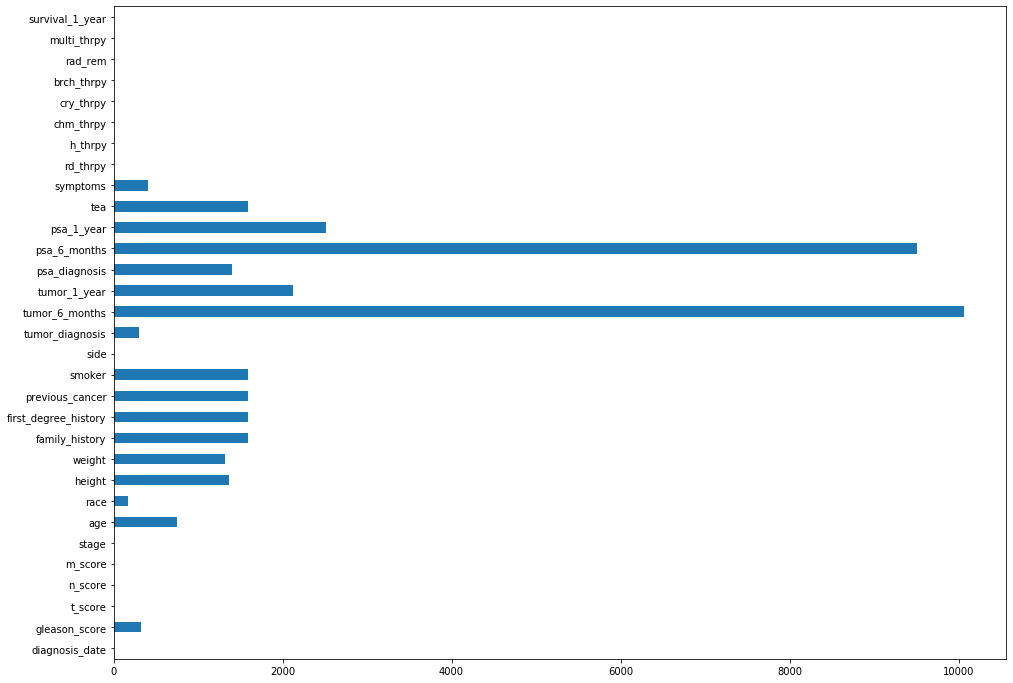

In [6]:
# 17 attributes constitutes missing value among them 16 are continous attributes and can be treated with regression techinique
plt.figure(figsize=(16, 12))
data.isnull().sum().plot(kind='barh')

#### Treating symptoms column (2.66% values are missing)

In [7]:
# Imputing it by its mode
data['symptoms'] = data['symptoms'].fillna(data['symptoms'].mode()[0])

#### Imputing missing values using Multiple_Imputation_by_Chained_Equations
https://www.researchgate.net/profile/Linda_Ejlskov/publication/316789124_Multiple_Imputation_by_Chained_Equations_in_Praxis_Guidelines_and_Review/links/5911bec0aca27200fe369a0f/Multiple-Imputation-by-Chained-Equations-in-Praxis-Guidelines-and-Review.pdf

In [8]:
missin_col_Names = data.select_dtypes('number').columns
imp_mean = IterativeImputer(random_state=0)
imp_mean.fit(data.select_dtypes('number'))
cont_df = pd.DataFrame(imp_mean.transform(data.select_dtypes('number')))
cont_df.columns = missin_col_Names
data = data.drop(missin_col_Names, axis = 1) 
data = pd.concat([data,cont_df], axis=1)
for column in data.columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

/home/anurag/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [9]:
print('Columns With Missing Values:', data.columns[data.isnull().any()])

Columns With Missing Values: Index([], dtype='object')


#### diagnosis_date

In [10]:
# Extracting month and year from the date
data['diagnosis_date'] = pd.to_datetime(data['diagnosis_date'])
data['Year'] = data['diagnosis_date'].dt.year
data['Month'] = data['diagnosis_date'].dt.month
d = dict(enumerate(calendar.month_abbr))
data['Month'] = data['Month'].map(d)
# Dropping column 'diagnosis_date' as day is all '1'
data = data.drop(['diagnosis_date'], axis = 1) 

#### symptoms

In [11]:
# symptoms columns have comma separated values. So converting it into dummies along with an aggregated column as total_symptoms
symp_df = data['symptoms'].str.get_dummies(sep=',').add_prefix('symptom_')
symp_df['total_symptoms'] = symp_df.sum(axis=1)
data = data.drop(['symptoms'], axis = 1) 
data = pd.concat([data,symp_df], axis=1)
data.head()

,t_score,n_score,m_score,stage,side,gleason_score,age,race,height,weight,family_history,first_degree_history,previous_cancer,smoker,tumor_diagnosis,tumor_6_months,tumor_1_year,psa_diagnosis,psa_6_months,psa_1_year,tea,rd_thrpy,h_thrpy,chm_thrpy,cry_thrpy,brch_thrpy,rad_rem,multi_thrpy,survival_1_year,Year,Month,symptom_O01,symptom_O08,symptom_O09,symptom_O10,symptom_O11,symptom_P01,symptom_P02,symptom_P03,symptom_S04,symptom_S07,symptom_S10,symptom_U01,symptom_U02,symptom_U03,symptom_U05,symptom_U06,total_symptoms
0,T1c,N0,M0,I,both,4.0,86.0,4.0,66.0,158.000000,0.0,0.0,0.0,0.0,70.0,48.414299,39.000000,8.70000,5.681268,4.200000,2.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,2005,Jun,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,T3a,N1,M0,IV,both,8.0,66.0,2.0,70.0,174.000000,0.0,0.0,0.0,1.0,43.0,28.000000,16.000000,13.70000,9.800000,7.500000,4.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2006,Feb,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2
2,T1a,N0,M0,IIB,right,9.0,84.0,4.0,69.0,174.192237,0.0,0.0,0.0,0.0,51.0,65.857005,89.000000,16.00000,15.900000,18.500000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,2006,Mar,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,4
3,T2b,N0,M0,IIB,right,8.0,86.0,3.0,69.0,173.000000,0.0,0.0,0.0,0.0,104.0,89.009823,82.055852,11.75726,9.818032,9.227457,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2005,Feb,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,4
4,T4,N0,M0,IV,left,8.0,78.0,4.0,70.0,201.000000,1.0,1.0,0.0,0.0,72.0,76.459681,87.000000,18.10000,18.087855,19.008855,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,2001,Dec,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,4


## 2. Exploratory Data Analysis

#### Some attributes are showing strong correlation<br>
1. Height and weight (BMI)<br>
2. tumor_diagnosis, tumor_6_months and tumor_1_year<br>
3. prostate-specific antigen (PSA diagnosis): at the time of diagnosis and 6 month & 1 year after diagnosis
4. family_history and first_degree_history : shows that prostate cancer highly correlated with first degree relation(brother and father) who have diagnosed with cancer<br>
5. Therapies in conjuction : When multiple therapies used in conjunction, highest correlation with rd_thrpy shows that Radio therapy used more oftenly followed by Hormone therapy and then Chemo therapy

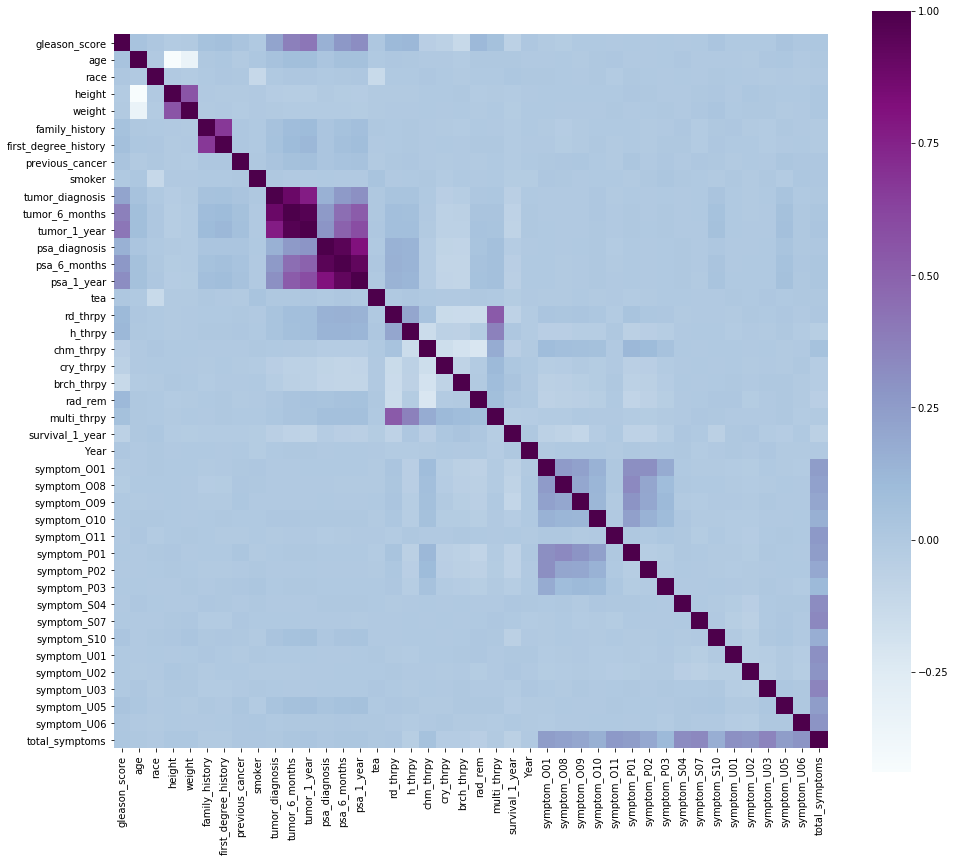

In [12]:
# Correaltion Matrix
plt.figure(figsize=(16,14))
sns.heatmap(data.corr(), cbar=True, square=True, annot_kws={'size': 10},cmap="BuPu")
plt.show()

### Analysing Target Varaible 
Overall Survial Rate : 43.22%

In [13]:
# NOT highly imbalance
# Deaths are more than the survival
survival_7_years.value_counts()

0    8168
1    6217
Name: survival_7_years, dtype: int64

1. gleason_score less than or equal to 8 portray more survival rate than of above 8 <br>
2. Similarly, age above 80 depicts higher death rate
3. Race 4 category accounts for very high number of patients than other category
4. Weight, tumor_6_months and tumor_diagnosis,  are slightly postively skewed 
5. Surprisingly, patients who undergoes Radio therapy proclaim higher death rate than patients who does not go for Radio therapy
6. Similarly higher chances of survival can be seen with the patients who doesnot go for hormonal therapy and chemotherapy

#### Creaing a dataset for the EDA purpose only

In [14]:
eda_dataset = pd.concat([data[:14385],survival_7_years], axis=1)

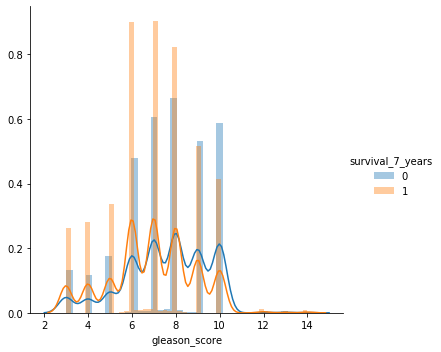

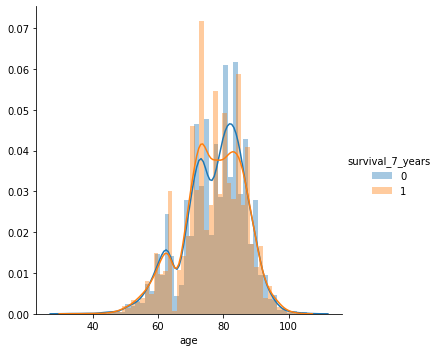

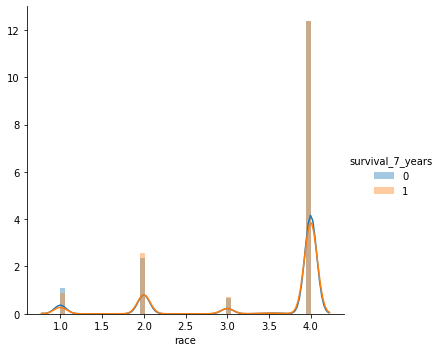

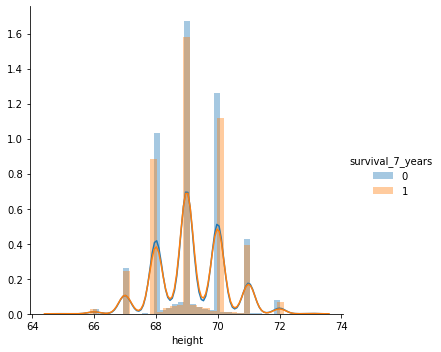

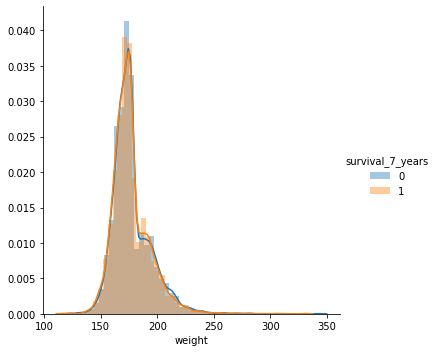

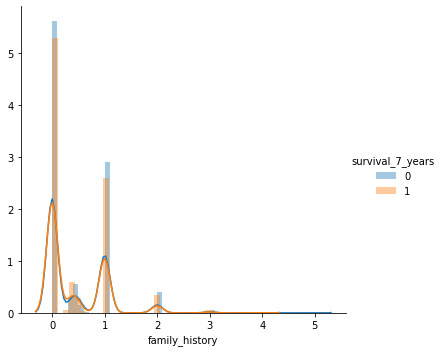

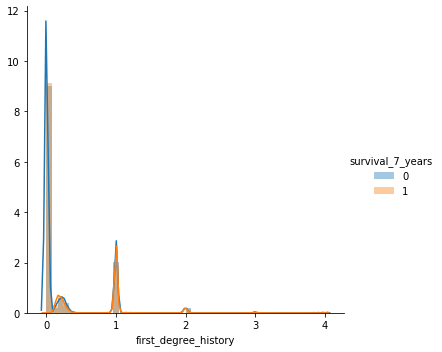

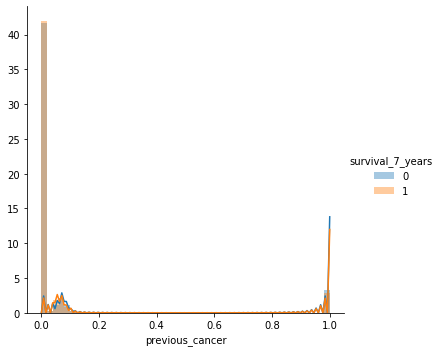

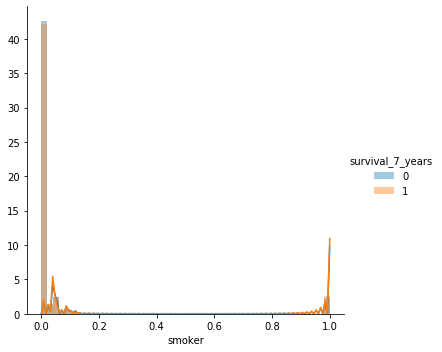

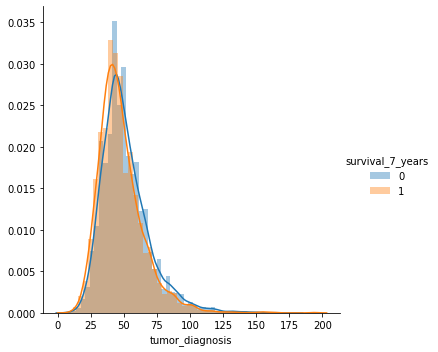

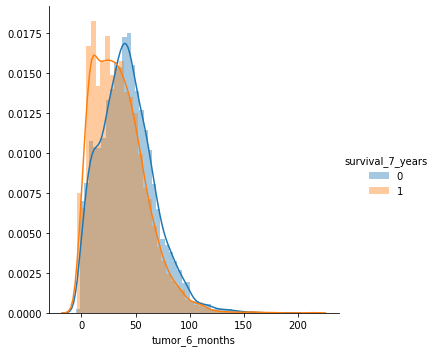

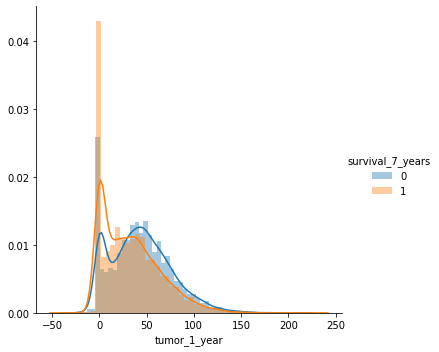

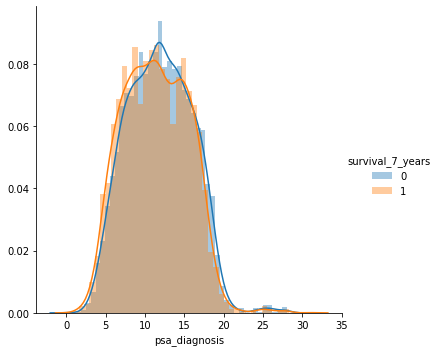

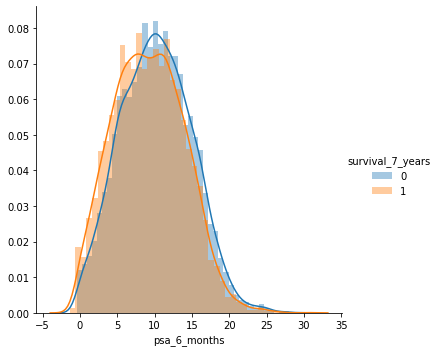

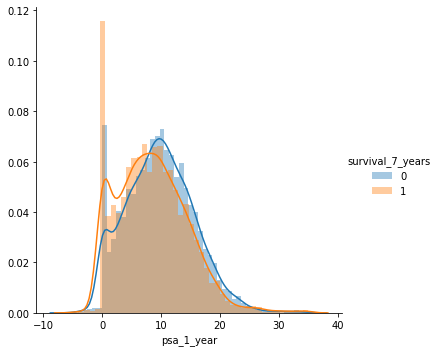

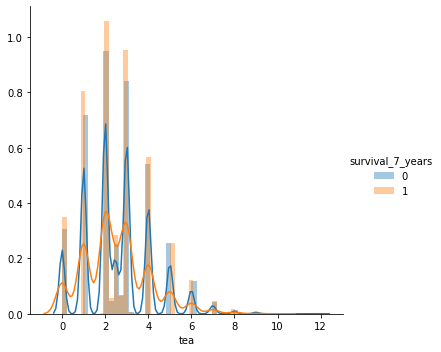

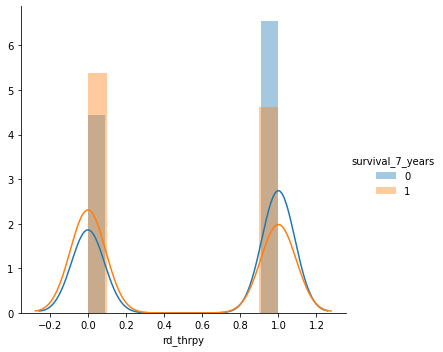

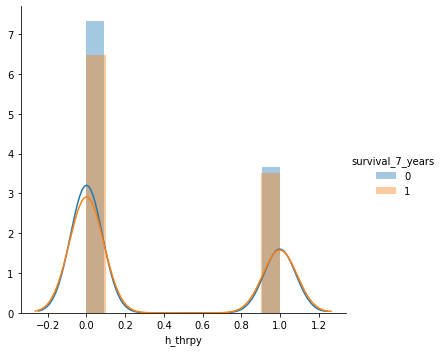

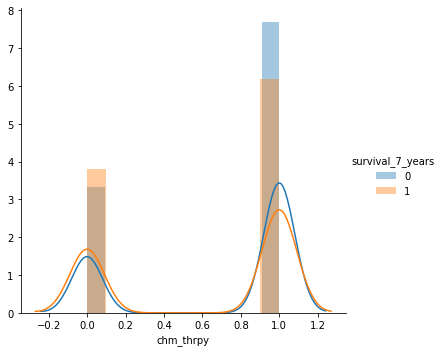

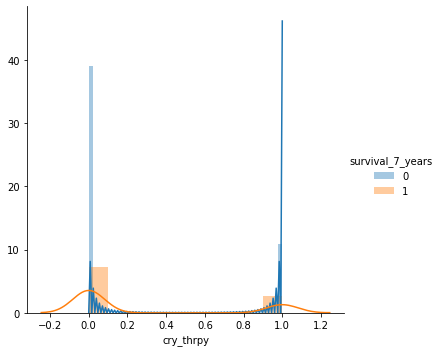

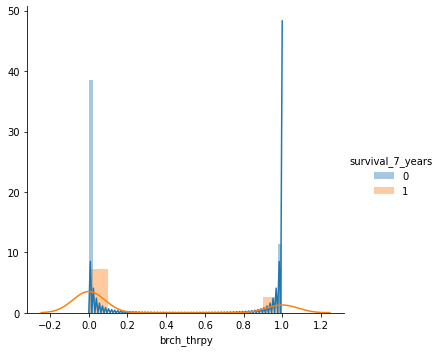

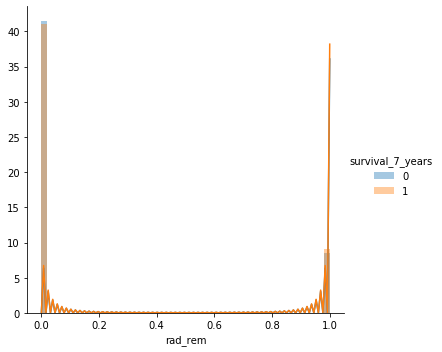

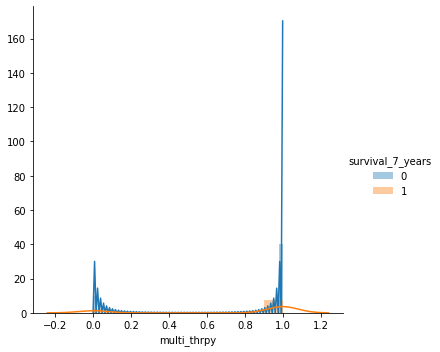

/home/anurag/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/anurag/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


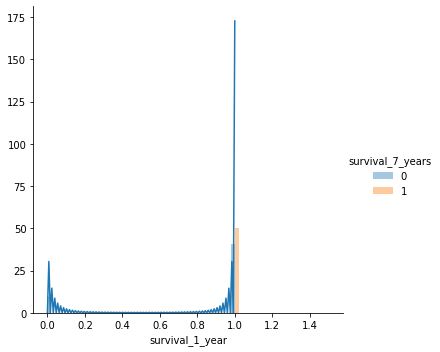

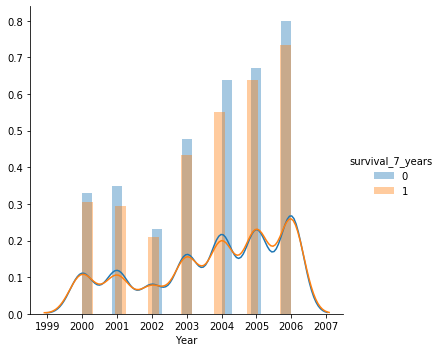

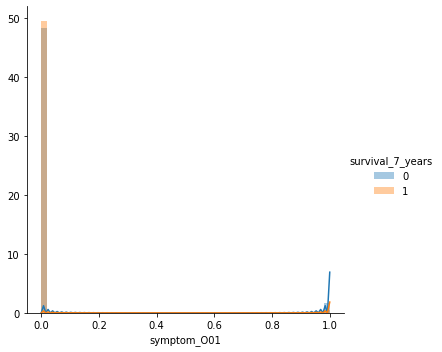

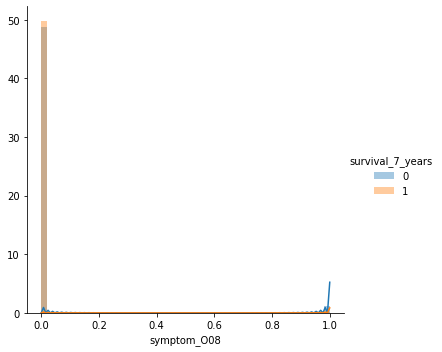

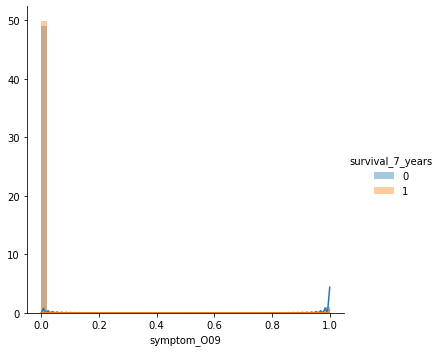

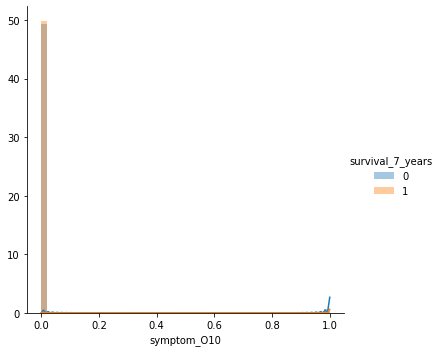

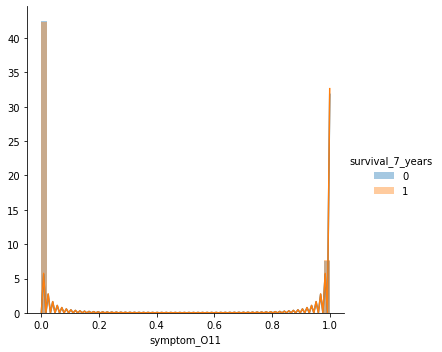

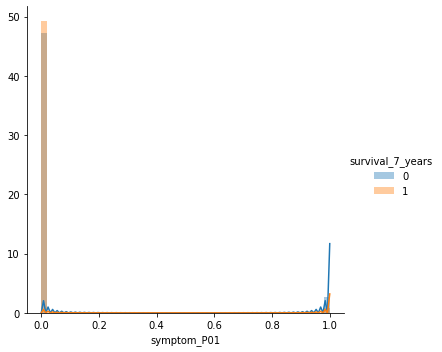

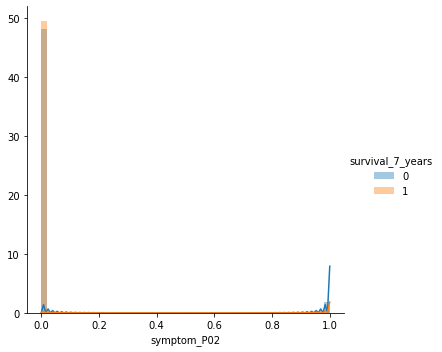

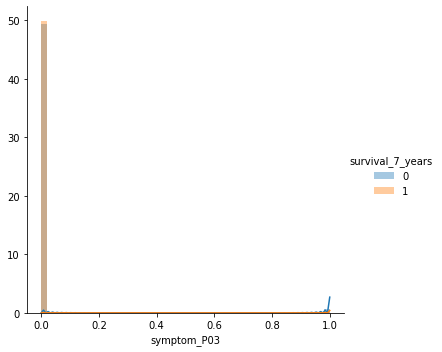

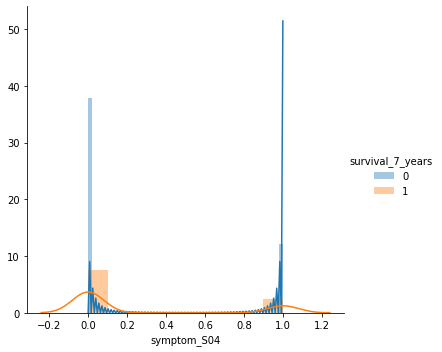

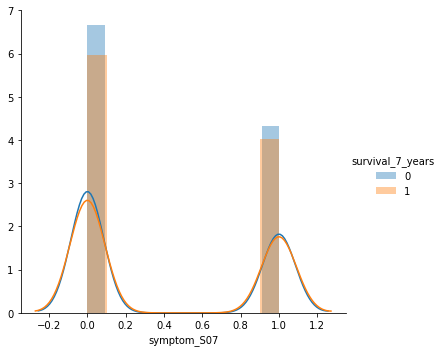

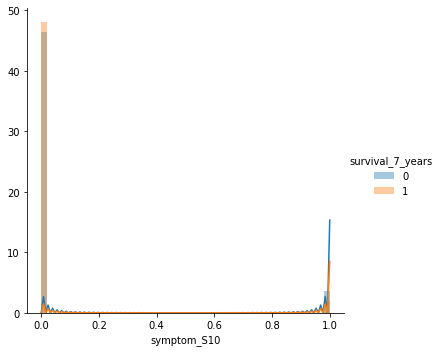

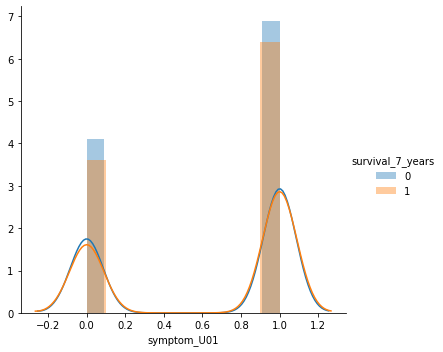

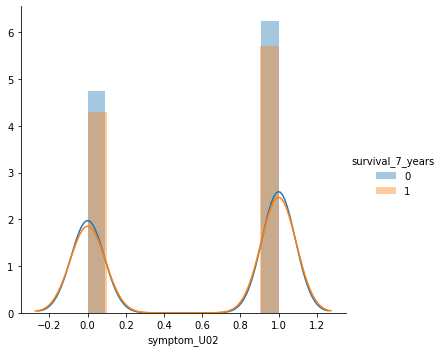

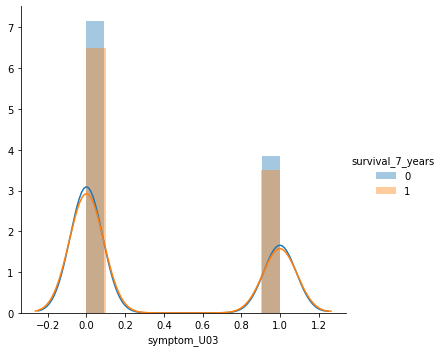

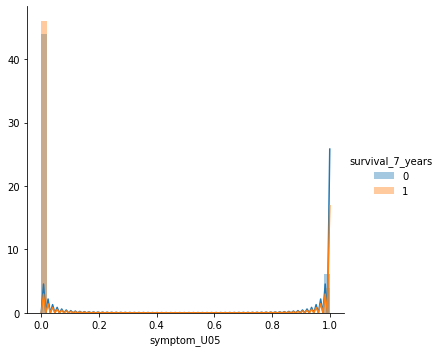

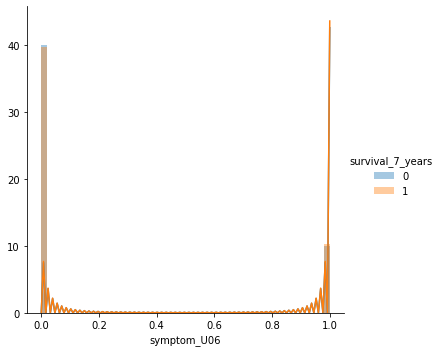

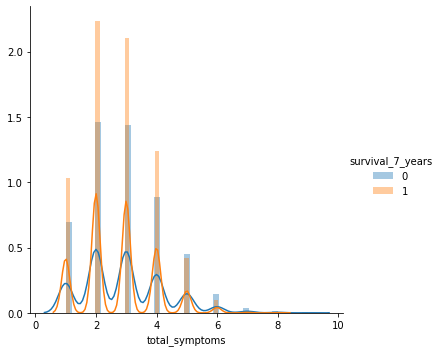

In [15]:
for idx, feature in enumerate(list(eda_dataset.select_dtypes('number').columns)[:-1]):
    fg = sns.FacetGrid(eda_dataset.select_dtypes('number'), hue='survival_7_years', height=5)
    fg.map(sns.distplot, feature).add_legend()
    plt.show()

### Survival Rate trend in Years

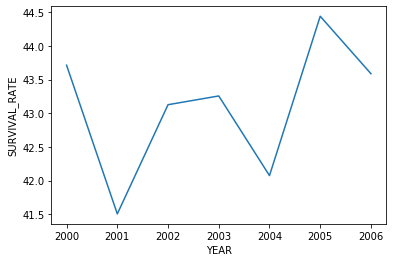

In [16]:
df_group_year_survRate=eda_dataset.groupby('Year').agg({'survival_7_years': lambda x: sum(x)*100/len(x)}).reset_index()
df_group_year_survRate.columns = ['YEAR','SURVIVAL_RATE']
ax = sns.lineplot(x="YEAR", y="SURVIVAL_RATE", data=df_group_year_survRate)

## 3. Data Preparation and Feature Engineering

### Creating BMI ratio using height and weight

In [17]:
data['bmi'] = (data['weight']*703)/(data['height']*data['height'])
data.loc[data['bmi'] < 18.5,'BMI_Category'] = 'UnderWeight'
data.loc[(data['bmi'] >= 18.5) & (data['bmi'] <=25),'BMI_Category'] = 'NormalWeight'
data.loc[(data['bmi'] > 25) & (data['bmi'] <=30),'BMI_Category'] = 'OverWeight'
data.loc[data['bmi']> 30,'BMI_Category'] = "Obesity"
data = data.drop(['height','weight'], axis = 1) 

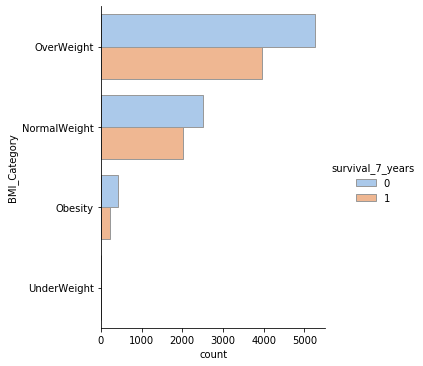

In [18]:
eda_dataset = pd.concat([data[:14385],survival_7_years], axis=1)
sns.catplot(y="BMI_Category", hue="survival_7_years", kind="count",palette="pastel", edgecolor=".6",data=eda_dataset);

### Treating stage attribute using mapping from stage 1 to 5

In [19]:
gen_ord_map = {'I': 1, 'IIA': 2, 'IIB': 3, 'III': 4, 'IV': 5}
data['stage'] = data['stage'].map(gen_ord_map)


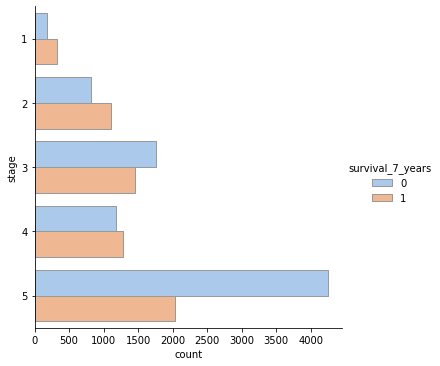

In [20]:
eda_dataset = pd.concat([data[:14385],survival_7_years], axis=1)
sns.catplot(y="stage", hue="survival_7_years", kind="count",palette="pastel", edgecolor=".6",data=eda_dataset);

### Creating Epochs

In [21]:
# Combinig month and year
data['Year'] = data['Year'].astype(str)
data['Period'] = data[['Month','Year']].agg('-'.join,axis=1)
data = data.merge(mon, on='Period')
data = data.drop(['Month','Year','Period'], axis = 1)

### Creating Dummy variables

In [22]:
cat_col = data.select_dtypes('object').columns
df_with_dummies = pd.get_dummies(data[cat_col], columns=cat_col)
data = data.drop(cat_col, axis = 1)
data = pd.concat([data, df_with_dummies], axis=1)

### Scaling

In [23]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)

### Dividing data to raw and validation dataset

In [24]:
raw = data_scaled.head(14385)
validation = data_scaled.tail(1000)

In [25]:
# Splitting the X and Y into the Training set and Testing set 
X_train, X_test, y_train, y_test = train_test_split(raw, survival_7_years, test_size = 0.3, random_state = 0)

## Model Building and Evaluation

### As the focus will be on overall accuracy mentioned in the question. We will test the KPI on the basis of accuracy and the F1-Score

In [26]:
score_list = []

#### 1. Logistic Regression

In [27]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(confusion_matrix(y_test,predictions))

/home/anurag/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[2395   40]
 [1837   44]]


In [28]:
lr_report = classification_report(y_test,predictions,output_dict=True)
score_list.append(('Logistic Regression',lr_report['accuracy'],lr_report['macro avg']['f1-score']))
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.57      0.98      0.72      2435
           1       0.52      0.02      0.04      1881

    accuracy                           0.57      4316
   macro avg       0.54      0.50      0.38      4316
weighted avg       0.55      0.57      0.42      4316



#### 2. Decision Tress 

In [29]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
dt_pred = dt_model.predict(X_test)
print(confusion_matrix(y_test,dt_pred))

[[1356 1079]
 [1069  812]]


In [30]:
dt_report = classification_report(y_test,dt_pred,output_dict=True)
score_list.append(('Decision_Tree',dt_report['accuracy'],lr_report['macro avg']['f1-score']))
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      2435
           1       0.43      0.43      0.43      1881

    accuracy                           0.50      4316
   macro avg       0.49      0.49      0.49      4316
weighted avg       0.50      0.50      0.50      4316



#### 3. Random Forest

In [31]:
rf= RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)
rf_pred=rf.predict(X_test)
print(confusion_matrix(y_test,rf_pred))

[[2212  223]
 [1698  183]]


In [32]:
rf_report = classification_report(y_test,rf_pred,output_dict=True)
score_list.append(('Random_Forest',rf_report['accuracy'],rf_report['macro avg']['f1-score']))
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.57      0.91      0.70      2435
           1       0.45      0.10      0.16      1881

    accuracy                           0.55      4316
   macro avg       0.51      0.50      0.43      4316
weighted avg       0.52      0.55      0.46      4316



#### 4. XGBoost

In [33]:
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(X_train,y_train)
xg_pred = xgboost.predict(X_test)
print(confusion_matrix(y_test,xg_pred))

[[1776  659]
 [1406  475]]


In [34]:
xg_report = classification_report(y_test,xg_pred,output_dict=True)
score_list.append(('XG_Boost',xg_report['accuracy'],rf_report['macro avg']['f1-score']))
print(classification_report(y_test,xg_pred))

              precision    recall  f1-score   support

           0       0.56      0.73      0.63      2435
           1       0.42      0.25      0.32      1881

    accuracy                           0.52      4316
   macro avg       0.49      0.49      0.47      4316
weighted avg       0.50      0.52      0.49      4316



#### 5. ANN Classifier

In [35]:
ann  = Sequential()
ann.add(Dense(units= 32,init= 'uniform', activation = 'relu', input_dim=66))
ann.add(Dense(units= 32,init= 'uniform', activation = 'relu'))
ann.add(Dense(units= 1,init= 'uniform', activation = 'sigmoid'))
ann.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
ann.fit(X_train,y_train, batch_size=32, nb_epoch=300,verbose= 0)

/home/anurag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=32, activation="relu", input_dim=66, kernel_initializer="uniform")`
  
/home/anurag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=32, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/anurag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoid", kernel_initializer="uniform")`
  after removing the cwd from sys.path.
/home/anurag/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


In [36]:
ann_pred = ann.predict(X_test)
ann_pred = [ 1 if y>=0.5 else 0 for y in ann_pred]
ann_pred_final = [ 1 if y>=0.4 else 0 for y in ann_pred]
print(confusion_matrix(y_test,ann_pred_final))

[[1372 1063]
 [1046  835]]


In [37]:
nn_report = classification_report(y_test,ann_pred_final,output_dict=True)
score_list.append(('Neural Net',nn_report['accuracy'],rf_report['macro avg']['f1-score']))
print(classification_report(y_test,ann_pred_final))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57      2435
           1       0.44      0.44      0.44      1881

    accuracy                           0.51      4316
   macro avg       0.50      0.50      0.50      4316
weighted avg       0.51      0.51      0.51      4316



### Models Performance

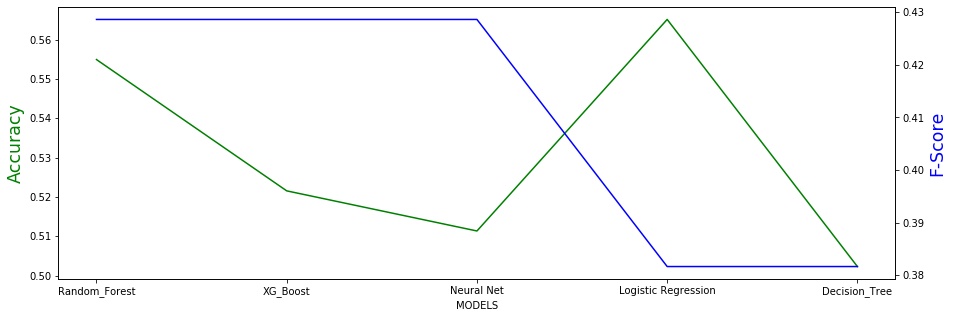

In [38]:
df = pd.DataFrame(score_list, columns =['Model', 'Accuracy', 'F-Score']).sort_values(by=['F-Score'],  ascending=False)
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx()
ax1.plot(df['Model'], df['Accuracy'], 'g-')
ax2.plot(df['Model'], df['F-Score'], 'b-')
ax1.set_xlabel('MODELS')
ax1.set_ylabel('Accuracy', color='g',fontsize ='xx-large')
ax2.set_ylabel('F-Score', color='b',fontsize ='xx-large')
plt.show()

## 5. Use test dataset

In [39]:
test = pd.read_csv("~/Downloads/DS/test.csv",index_col=0)

In [40]:
test_prediction = rf.predict(validation)
test = test.drop(['survival_7_years'], axis=1)
test['survival_7_years'] = test_prediction

In [43]:
test.to_csv('new_test.csv' , index=False)